In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mlflow

# Set MLFlow Experiment
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment(experiment_name="recommendation_system")

<Experiment: artifact_location='mlflow-artifacts:/753183866456602941', creation_time=1721774674814, experiment_id='753183866456602941', last_update_time=1721774674814, lifecycle_stage='active', name='recommendation_system', tags={}>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

from keras import Model
from keras.layers import Embedding, Input, Flatten, Dot, Add, Concatenate, Dense, Lambda
from keras.optimizers import Adam
from keras.regularizers import l2
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.utils import plot_model

from tqdm import tqdm

## Load Data

In [4]:
movies = pd.read_csv("data/peliculas.csv")
scores = pd.read_csv("data/scores.csv", index_col=0)
users = pd.read_csv("data/usuarios.csv")
people = pd.read_csv("data/personas.csv")

## SVD

In [5]:
def SVD(users_items_train_matrix, k = 20):
    # Get SVD components from train matrix. Choose k.
    u, s, vt = svds(users_items_train_matrix, k)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    return X_pred

In [6]:
def rmse(R, R_estimated):
    # It is not commutative, first goes the ground truth (R_test), second goes the predictions
    # The order is necessary for the nonzero be the ground truth
    nonzeros = R.nonzero()
    prediction = R_estimated[nonzeros].flatten()
    ground_truth = R[nonzeros].flatten()
    return np.sqrt(((prediction - ground_truth)**2).sum()/ground_truth.shape[0])

In [7]:
def split_dataset(data, test_size=0.2):
    n_users = data.user_id.unique().shape[0]
    n_items = data.movie_id.unique().shape[0]
    train_df = np.zeros((n_users, n_items))
    train_data, test_data = train_test_split(data, test_size=0.2)
    for line in train_data.itertuples():
        train_df[line[1]-1, line[2]-1] = line[3]
    
    test_df = np.zeros((n_users, n_items))
    for line in test_data.itertuples():
        test_df[line[1]-1, line[2]-1] = line[3]
    return train_df, test_df

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  9.50it/s]


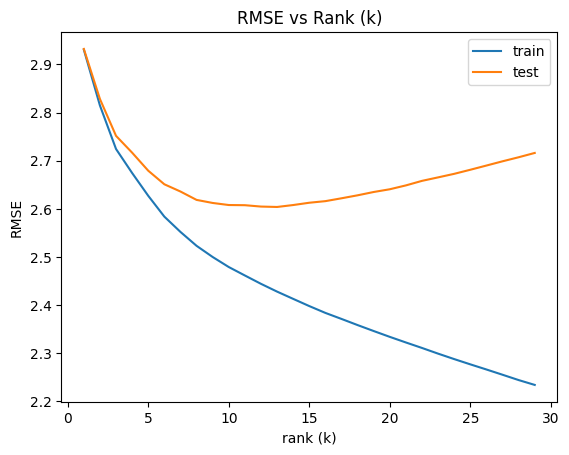

2024/09/01 17:55:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVD at: http://127.0.0.1:5000/#/experiments/753183866456602941/runs/bcac8fc9eecd44c19fe4cb0018f6fce6.
2024/09/01 17:55:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/753183866456602941.


Best RMSE: 2.603897197937303 for k=13


In [8]:
with mlflow.start_run(run_name="SVD"):
    # split dataset
    R_train, R_test = split_dataset(scores, test_size=0.2)

    mse_train = []
    mse_test = []
    ks = range(1, 30, 1)
    best_k = 0
    best_mse = float('inf')
    for k in tqdm(ks):
        SVD_Predictions = SVD(R_train, k=k)
        train_rmse = rmse(R_train, SVD_Predictions)
        test_rmse = rmse(R_test, SVD_Predictions)
        mse_train.append(train_rmse)
        mse_test.append(test_rmse)

        # Log RMSE for each k
        mlflow.log_metric(f'rmse_train_k_{k}', train_rmse)
        mlflow.log_metric(f'rmse_test_k_{k}', test_rmse)

        if test_rmse < best_mse:
            best_mse = test_rmse
            best_k = k
            
    plt.plot(ks, mse_train, label='train')
    plt.plot(ks, mse_test, label='test')
    plt.xlabel('rank (k)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title("RMSE vs Rank (k)")

    # Save the plot to a file
    plt_path = "rmse_vs_rank.png"
    plt.savefig(plt_path)
    plt.show()
    plt.close()

    # Log parameters, best k, best rmse and the plot
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("k_range", list(ks))
    mlflow.log_metric("best_rmse", best_mse)
    mlflow.log_param("best_k", best_k)
    mlflow.log_artifact(plt_path)
    
    print(f"Best RMSE: {best_mse} for k={best_k}")

## SVD + Mean

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 10.13it/s]


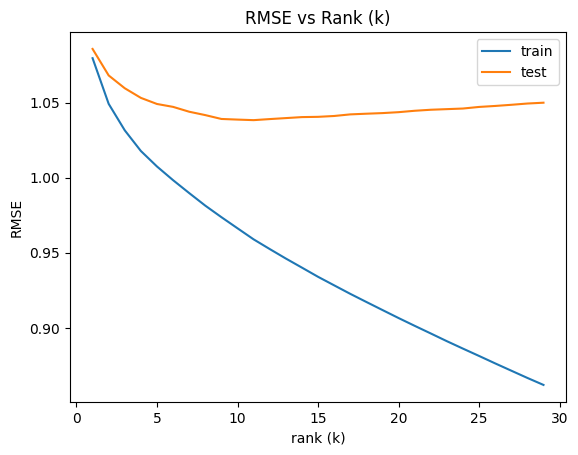

2024/09/01 17:55:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVD + Mean at: http://127.0.0.1:5000/#/experiments/753183866456602941/runs/e01ac76740ad4034be8e65363dfae422.
2024/09/01 17:55:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/753183866456602941.


Best RMSE: 1.0383515186113343 for k=11


In [9]:
with mlflow.start_run(run_name="SVD + Mean"):
    # split dataset
    R_train, R_test = split_dataset(scores, test_size=0.2)

    # Calculate Mean
    mu = R_train[R_train.nonzero()].mean()
    # Substract the mean to non zero values
    R_train_norm = (R_train - mu)*(R_train>0) 

    mse_train = []
    mse_test = []
    ks = range(1, 30, 1)
    best_k = 0
    best_mse = float('inf')
    for k in tqdm(ks):
        SVD_Predictions_norm = SVD(R_train_norm, k=k) + mu
        train_rmse = rmse(R_train, SVD_Predictions_norm)
        test_rmse = rmse(R_test, SVD_Predictions_norm)
        mse_train.append(train_rmse)
        mse_test.append(test_rmse)

        # Log RMSE for each k
        mlflow.log_metric(f'rmse_train_k_{k}', train_rmse)
        mlflow.log_metric(f'rmse_test_k_{k}', test_rmse)

        if test_rmse < best_mse:
            best_mse = test_rmse
            best_k = k
            
    plt.plot(ks, mse_train, label='train')
    plt.plot(ks, mse_test, label='test')
    plt.xlabel('rank (k)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title("RMSE vs Rank (k)")

    # Save the plot to a file
    plt_path = "rmse_vs_rank.png"
    plt.savefig(plt_path)
    plt.show()
    plt.close()

    # Log parameters, best k, best rmse and the plot
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("k_range", list(ks))
    mlflow.log_metric("best_rmse", best_mse)
    mlflow.log_param("best_k", best_k)
    mlflow.log_artifact(plt_path)
    
    print(f"Best RMSE: {best_mse} for k={best_k}")

## SVD + Baselines

In [10]:
def getBaselineEstimates(R, mu, lambda1 = 0, lambda2 = 0, items_first = True, not_rated = 0):
    if not items_first:
        R = R.T
        
    (m,n) = R.shape
    bui = np.zeros((m,1))
    bii = np.zeros((n,1))

    for item in range(n):
        where = np.where(R[:,item]!=not_rated)
        item_rates = R[where,item]
        num = len(item_rates[0])
        if (num>0):
            bii[item] = (item_rates.sum() - mu*num)/(num+lambda1)
    for user in range(m):
        where = np.where(R[user,:]!=not_rated)
        user_rates = R[user,where]
        num = len(where[0])
        
        if (num>0):
            bui[user] = ((user_rates.T-bii[where]).sum() - num*mu)/(num+lambda2)
            
    if items_first:
        return bui, bii
    else:
        return bii, bui

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  9.20it/s]


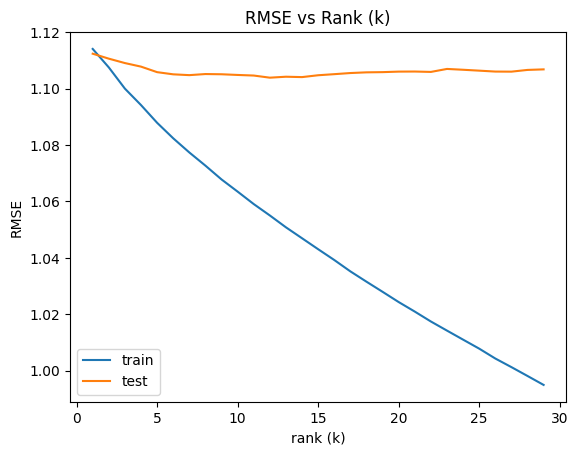

2024/09/01 17:55:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVD + Baselines at: http://127.0.0.1:5000/#/experiments/753183866456602941/runs/c86972f4194c4e4d87d2b2c737e67eea.
2024/09/01 17:55:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/753183866456602941.


Best RMSE: 1.103907062962547 for k=12


In [11]:
with mlflow.start_run(run_name="SVD + Baselines"):
    # split dataset
    R_train, R_test = split_dataset(scores, test_size=0.2)

    # Calculate Mean + Baseline
    mu = R_train[R_train.nonzero()].mean()
    bii, bui = getBaselineEstimates(R_train, mu)
    baseline = mu + bui + bii.T
    # Substract the mean to non zero values
    
    R_train_baseline = (R_train - baseline.T)*(R_train>0) 

    mse_train = []
    mse_test = []
    ks = range(1, 30, 1)
    best_k = 0
    best_mse = float('inf')
    for k in tqdm(ks):
        SVD_Predictions_norm = SVD(R_train_baseline, k=k) + mu
        train_rmse = rmse(R_train, SVD_Predictions_norm)
        test_rmse = rmse(R_test, SVD_Predictions_norm)
        mse_train.append(train_rmse)
        mse_test.append(test_rmse)

        # Log RMSE for each k
        mlflow.log_metric(f'rmse_train_k_{k}', train_rmse)
        mlflow.log_metric(f'rmse_test_k_{k}', test_rmse)

        if test_rmse < best_mse:
            best_mse = test_rmse
            best_k = k
            
    plt.plot(ks, mse_train, label='train')
    plt.plot(ks, mse_test, label='test')
    plt.xlabel('rank (k)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title("RMSE vs Rank (k)")

    # Save the plot to a file
    plt_path = "rmse_vs_rank.png"
    plt.savefig(plt_path)
    plt.show()
    plt.close()

    # Log parameters, best k, best rmse and the plot
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("k_range", list(ks))
    mlflow.log_metric("best_rmse", best_mse)
    mlflow.log_param("best_k", best_k)
    mlflow.log_artifact(plt_path)
    
    print(f"Best RMSE: {best_mse} for k={best_k}")

# Neural Networks

## Prepare Data

In [12]:
# Create a deep copy of the scores dataset since we are going to modify it.
ratings = scores.copy()

# Create a dictionary of indexes for the users and movies maping every ID to a given index.
u_unique = ratings.user_id.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movie_id.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

# Replace the users and movies ids with the new index value.
ratings.user_id = ratings.user_id.apply(lambda x: user2Idx[x])
ratings.movie_id = ratings.movie_id.apply(lambda x: movie2Idx[x])

n_users = int(ratings.user_id.nunique())
n_movies = int(ratings.movie_id.nunique())

## Keras

### Model

In [13]:
def build_keras_model(users_number, movies_number, latent_factors=5, add_bias=False, loss="mean_squared_error", learning_rate=0.001, metrics=["root_mean_squared_error"]):
    movie_input = Input(shape=[1], name='Item')
    user_input = Input(shape=[1],name='User')
    
    # Movie Embedding Layer
    movie_embedding = Embedding(
        movies_number + 1, 
        latent_factors, 
        embeddings_regularizer=l2(0.001),
        name='Movie-Embedding'
    )(movie_input)
    
    movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
    
    # User Embedding Layer
    user_embedding = Embedding(
        users_number + 1, 
        latent_factors, 
        name='User-Embedding'
    )(user_input)

    user_vec = Flatten(name='FlattenUsers')(user_embedding)
    
    prod = Dot(axes=1, name='DotProduct')([movie_vec, user_vec])
    
    if add_bias:
        # Movie Bias Embedding Layer
        movie_bias_embedding = Embedding(
            movies_number + 1, 
            1, 
            embeddings_regularizer=l2(0.001),
            name='Movie-Bias-Embedding'
        )(movie_input)
        movie_bias = Flatten(name='FlattenMoviesBias')(movie_bias_embedding)
        
        # User Bias Embedding Layer
        user_bias_embedding = Embedding(
            users_number + 1, 
            1, 
            name='User-Bias-Embedding'
        )(user_input)
        user_bias = Flatten(name='FlattenUserBias')(user_bias_embedding)
        prod = Add()([prod, user_bias, movie_bias])

    model = Model([user_input, movie_input], prod)
    model.compile(Adam(learning_rate=learning_rate), loss, metrics=metrics)
    return model

### Train Model

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Movie-Embedding (Embedding)   │ (None, 1, 5)              │           8,415 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User-Embedding (Embedding)    │ (None, 1, 5)              │           4,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenMovies (Flatten)       │ (None, 5)                 │               0 │ Movie-Embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUsers (Flatten)        │ (None, 5)                 │               0 │ User-Embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ DotProduct (Dot)              │ (None, 1)                 │               0 │ FlattenMovies[0][0],       │
│                               │                           │                 │ FlattenUsers[0][0]         │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 13,135 (51.31 KB)

 Trainable params: 13,135 (51.31 KB)

 Non-trainable params: 0 (0.00 B)

  0%|                                                                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - loss: 1.1821 - root_mean_squared_error: 0.9284
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 1.2695 - root_mean_squared_error: 0.9743


 12%|████████████████████████                                                                                                                                                                        | 1/8 [00:28<03:21, 28.85s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - loss: 0.9782 - root_mean_squared_error: 0.8483
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 1.1299 - root_mean_squared_error: 0.9334


 25%|████████████████████████████████████████████████                                                                                                                                                | 2/8 [00:58<02:56, 29.39s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 677us/step - loss: 0.8968 - root_mean_squared_error: 0.7980
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 1.1333 - root_mean_squared_error: 0.9345


 38%|████████████████████████████████████████████████████████████████████████                                                                                                                        | 3/8 [01:29<02:30, 30.16s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - loss: 0.8777 - root_mean_squared_error: 0.7837
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 1.1333 - root_mean_squared_error: 0.9326


 50%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 4/8 [02:00<02:01, 30.48s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - loss: 0.8667 - root_mean_squared_error: 0.7772
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 1.1403 - root_mean_squared_error: 0.9368


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 5/8 [02:30<01:31, 30.41s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - loss: 0.8487 - root_mean_squared_error: 0.7665
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 1.1373 - root_mean_squared_error: 0.9359


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 6/8 [03:01<01:00, 30.30s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - loss: 0.8341 - root_mean_squared_error: 0.7553
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 1.1324 - root_mean_squared_error: 0.9321


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 7/8 [03:31<00:30, 30.34s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step - loss: 0.7780 - root_mean_squared_error: 0.7110
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 1.1497 - root_mean_squared_error: 0.9366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:02<00:00, 30.26s/it]


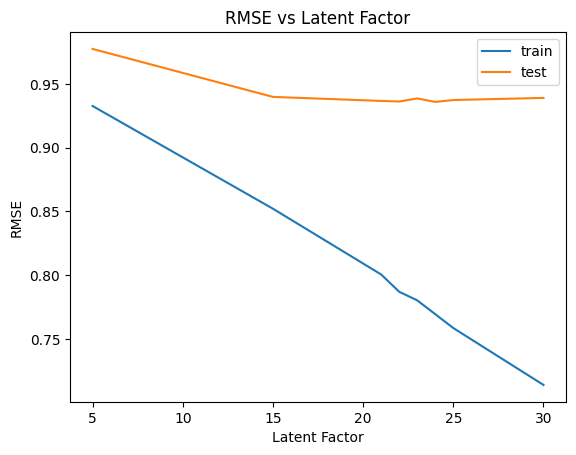

2024/09/01 18:04:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run Keras at: http://127.0.0.1:5000/#/experiments/753183866456602941/runs/5e0494e0707e480c97803a98e8aa7c73.
2024/09/01 18:04:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/753183866456602941.


Best RMSE: 0.9359835982322693 for latent_factor=24


In [15]:
with mlflow.start_run(run_name="Keras"):
    # split dataset
    eval_size = 0.1
    test_size = 0.2
    ratings_train, ratings_val = train_test_split(ratings, test_size=eval_size)
    ratings_train, ratings_test = train_test_split(ratings_train, test_size=test_size)
    
    mse_train = []
    mse_test = []
    best_lf = 0
    best_mse = float('inf')
    epochs=100
    latent_factor_list = [5, 15, 21, 22, 23, 24, 25, 30]
    model = build_keras_model(n_users, n_movies)
    model.summary()
    _ = plot_model(model, to_file="keras-model.png", show_layer_names=True, show_layer_activations=True,show_trainable=True)
    for lf in tqdm(latent_factor_list):
        model = build_keras_model(n_users, n_movies, latent_factors=lf)
        summary=False
        history = model.fit(
            [ratings_train.user_id, ratings_train.movie_id], 
            ratings_train.rating, 
            batch_size=320,
            validation_data=([ratings_test.user_id, ratings_test.movie_id], ratings_test.rating), 
            epochs=epochs,
            verbose=0
        )
        metrics_train = model.evaluate([ratings_train.user_id, ratings_train.movie_id], ratings_train.rating)
        metrics_val = model.evaluate([ratings_val.user_id, ratings_val.movie_id], ratings_val.rating)

        mse_train.append(metrics_train[1])
        mse_test.append(metrics_val[1])

        
        # Log RMSE for each k
        mlflow.log_metric(f'rmse_train_lf_{lf}', metrics_train[1])
        mlflow.log_metric(f'rmse_test_lf_{lf}', metrics_val[1])

        if metrics_val[1] < best_mse:
            best_mse = metrics_val[1]
            best_lf = lf
    
    plt.plot(latent_factor_list, mse_train, label='train')
    plt.plot(latent_factor_list, mse_test, label='test')
    plt.xlabel('Latent Factor')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title("RMSE vs Latent Factor")

    # Save the plot to a file
    plt_path = "rmse_vs_latent_factor.png"
    plt.savefig(plt_path)
    plt.show()
    plt.close()

    # Log parameters, best latent_factor, best rmse and the plot
    mlflow.log_param("eval_size", eval_size)
    mlflow.log_param("test_size", test_size)
    mlflow.log_param("latent_factor", latent_factor_list)
    mlflow.log_metric("best_rmse", best_mse)
    mlflow.log_param("best_lf", best_lf)
    mlflow.log_artifact(plt_path)
    mlflow.log_artifact("keras-model.png")
    
    print(f"Best RMSE: {best_mse} for latent_factor={best_lf}")

## Keras + Baseline

### Train Model

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Movie-Embedding (Embedding)   │ (None, 1, 5)              │           8,415 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User-Embedding (Embedding)    │ (None, 1, 5)              │           4,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenMovies (Flatten)       │ (None, 5)                 │               0 │ Movie-Embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUsers (Flatten)        │ (None, 5)                 │               0 │ User-Embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ DotProduct (Dot)              │ (None, 1)                 │               0 │ FlattenMovies[0][0],       │
│                               │                           │                 │ FlattenUsers[0][0]         │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 13,135 (51.31 KB)

 Trainable params: 13,135 (51.31 KB)

 Non-trainable params: 0 (0.00 B)

  0%|                                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - loss: 0.8621 - root_mean_squared_error: 0.8866
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.9365 - root_mean_squared_error: 0.9274


 10%|███████████████████                                                                                                                                                                            | 1/10 [00:29<04:29, 29.92s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step - loss: 0.7717 - root_mean_squared_error: 0.8129
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.9366 - root_mean_squared_error: 0.9085


 20%|██████████████████████████████████████▏                                                                                                                                                        | 2/10 [01:00<04:01, 30.14s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - loss: 0.7491 - root_mean_squared_error: 0.7943
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.9387 - root_mean_squared_error: 0.9057


 30%|█████████████████████████████████████████████████████████▎                                                                                                                                     | 3/10 [01:30<03:31, 30.20s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - loss: 0.7471 - root_mean_squared_error: 0.7915
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 0.9542 - root_mean_squared_error: 0.9127


 40%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 4/10 [02:03<03:07, 31.30s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - loss: 0.7414 - root_mean_squared_error: 0.7863
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.9482 - root_mean_squared_error: 0.9081


 50%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 5/10 [02:36<02:39, 31.82s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - loss: 0.7166 - root_mean_squared_error: 0.7654
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.9581 - root_mean_squared_error: 0.9094


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 6/10 [03:08<02:08, 32.03s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - loss: 0.7059 - root_mean_squared_error: 0.7560
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 0.9612 - root_mean_squared_error: 0.9091


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 7/10 [03:40<01:35, 31.89s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 0.6732 - root_mean_squared_error: 0.7269
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.9774 - root_mean_squared_error: 0.9122


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 8/10 [04:11<01:03, 31.67s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - loss: 0.6206 - root_mean_squared_error: 0.6769
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 1.0114 - root_mean_squared_error: 0.9212


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 9/10 [04:42<00:31, 31.51s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - loss: 0.5801 - root_mean_squared_error: 0.6367
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 1.0288 - root_mean_squared_error: 0.9239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:14<00:00, 31.43s/it]


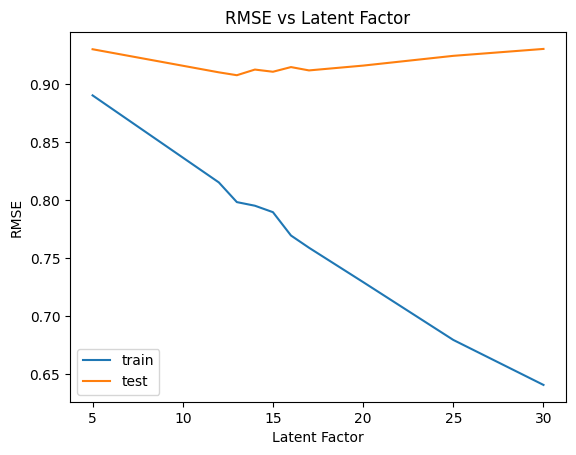

2024/09/01 18:09:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run Keras + Baseline at: http://127.0.0.1:5000/#/experiments/753183866456602941/runs/79438cf49df8447894a4809c58235e75.
2024/09/01 18:09:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/753183866456602941.


Best RMSE: 0.9076674580574036 for latent_factor=13


In [16]:
with mlflow.start_run(run_name="Keras + Baseline"):
    # split dataset
    eval_size = 0.1
    test_size = 0.2
    ratings_train, ratings_val = train_test_split(ratings, test_size=eval_size)
    ratings_train, ratings_test = train_test_split(ratings_train, test_size=test_size)
    
    mse_train = []
    mse_test = []
    best_lf = 0
    best_mse = float('inf')
    epochs=100
    latent_factor_list = [5, 12, 13, 14, 15, 16, 17, 20, 25, 30]
    model = build_keras_model(n_users, n_movies)
    model.summary()
    _ = plot_model(model, to_file="keras-model.png", show_layer_names=True, show_layer_activations=True,show_trainable=True)
    for lf in tqdm(latent_factor_list):
        model = build_keras_model(n_users, n_movies, latent_factors=lf, add_bias=True)
        history = model.fit(
            [ratings_train.user_id, ratings_train.movie_id], 
            ratings_train.rating, 
            batch_size=320,
            validation_data=([ratings_test.user_id, ratings_test.movie_id], ratings_test.rating), 
            epochs=epochs,
            verbose=0
        )
        metrics_train = model.evaluate([ratings_train.user_id, ratings_train.movie_id], ratings_train.rating)
        metrics_val = model.evaluate([ratings_val.user_id, ratings_val.movie_id], ratings_val.rating)
        
        mse_train.append(metrics_train[1])
        mse_test.append(metrics_val[1])

        # Log RMSE for each k
        mlflow.log_metric(f'rmse_train_lf_{lf}', metrics_train[1])
        mlflow.log_metric(f'rmse_test_lf_{lf}', metrics_val[1])

        if metrics_val[1] < best_mse:
            best_mse = metrics_val[1]
            best_lf = lf
            
    plt.plot(latent_factor_list, mse_train, label='train')
    plt.plot(latent_factor_list, mse_test, label='test')
    plt.xlabel('Latent Factor')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title("RMSE vs Latent Factor")

    # Save the plot to a file
    plt_path = "rmse_vs_latent_factor.png"
    plt.savefig(plt_path)
    plt.show()
    plt.close()

    # Log parameters, best latent_factor, best rmse and the plot
    mlflow.log_param("eval_size", eval_size)
    mlflow.log_param("test_size", test_size)
    mlflow.log_param("latent_factor", latent_factor_list)
    mlflow.log_metric("best_rmse", best_mse)
    mlflow.log_param("best_lf", best_lf)
    mlflow.log_artifact(plt_path)
    mlflow.log_artifact("keras-model.png")
    
    print(f"Best RMSE: {best_mse} for latent_factor={best_lf}")

## Keras + Genres

### Prepare Data

In [17]:
genres_cols = movies.select_dtypes(include=["int64"]).columns.to_list()
genres = movies[genres_cols].copy()
genres_cols.remove("id") # Remove the id column to keep only genres

In [18]:
genres.id = genres.id.apply(lambda x: movie2Idx[x])
genres.rename(columns={"id":"movie_id"}, inplace=True)
n_genres = len(genres_cols)

In [19]:
ratings_with_genres = pd.merge(
    ratings,
    genres,
    on="movie_id"
)

### Model 

In [20]:
def build_keras_model(
    users_number, 
    movies_number, 
    genres_number,
    max_rating=5,
    min_rating=1,
    latent_factors=5, 
    loss="mean_squared_error", 
    learning_rate=0.001, 
    metrics=["root_mean_squared_error"]
):
    movie_input = Input(shape=[1], name='Item')
    user_input = Input(shape=[1], name='User')
    genre_input = Input(shape=[genres_number], name='Genres')

    # Movie Embedding Layer
    movie_embedding = Embedding(
        movies_number + 1, 
        latent_factors, 
        embeddings_regularizer=l2(0.001),
        name='Movie-Embedding'
    )(movie_input)
    
    movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

    # User Embedding Layer
    user_embedding = Embedding(
        users_number + 1, 
        latent_factors, 
        embeddings_regularizer=l2(0.001),
        name='User-Embedding'
    )(user_input)

    user_vec = Flatten(name='FlattenUsers')(user_embedding)
    # prod = Dot(axes=1, name='DotProduct')([user_vec, movie_vec])
    
    # Concatenate the movie_vec with the genre_input
    concat = Concatenate(name='Concatenate')([user_vec, movie_vec, genre_input])
    full_connect = Dense(50,name='FullyConnected', activation='relu', kernel_regularizer=l2(0.001))(concat)
    x = Dense(1, activation='sigmoid',name='Activation')(full_connect)
    score = Lambda(lambda z: (max_rating - min_rating) * z + min_rating, name="Standarization")(x)
    model = Model(inputs=[user_input, movie_input, genre_input], outputs=score)
    model.compile(Adam(learning_rate=learning_rate), loss=loss, metrics=metrics)
    return model

### Train Model

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User-Embedding (Embedding)    │ (None, 1, 5)              │           4,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Movie-Embedding (Embedding)   │ (None, 1, 5)              │           8,415 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUsers (Flatten)        │ (None, 5)                 │               0 │ User-Embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenMovies (Flatten)       │ (None, 5)                 │               0 │ Movie-Embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Genres (InputLayer)           │ (None, 19)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Concatenate (Concatenate)     │ (None, 29)                │               0 │ FlattenUsers[0][0],        │
│                               │                           │                 │ FlattenMovies[0][0],       │
│                               │                           │                 │ Genres[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FullyConnected (Dense)        │ (None, 50)                │           1,500 │ Concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Activation (Dense)            │ (None, 1)                 │              51 │ FullyConnected[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Standarization (Lambda)       │ (None, 1)                 │               0 │ Activation[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,686 (57.37 KB)

 Trainable params: 14,686 (57.37 KB)

 Non-trainable params: 0 (0.00 B)

  0%|                                                                                                                                                                                                        | 0/9 [00:00<?, ?it/s]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 684us/step - loss: 0.8450 - root_mean_squared_error: 0.9088
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 0.8989 - root_mean_squared_error: 0.9377


 11%|█████████████████████▎                                                                                                                                                                          | 1/9 [00:29<03:54, 29.30s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step - loss: 0.7822 - root_mean_squared_error: 0.8635
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.8870 - root_mean_squared_error: 0.9220


 22%|██████████████████████████████████████████▋                                                                                                                                                     | 2/9 [00:54<03:06, 26.63s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step - loss: 0.7844 - root_mean_squared_error: 0.8638
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 0.8863 - root_mean_squared_error: 0.9207


 33%|████████████████████████████████████████████████████████████████                                                                                                                                | 3/9 [01:19<02:35, 25.90s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - loss: 0.7462 - root_mean_squared_error: 0.8325
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.8933 - root_mean_squared_error: 0.9166


 44%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 4/9 [01:46<02:11, 26.30s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - loss: 0.7154 - root_mean_squared_error: 0.8059
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.8935 - root_mean_squared_error: 0.9096


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 5/9 [02:13<01:47, 26.87s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - loss: 0.6947 - root_mean_squared_error: 0.7884
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.9110 - root_mean_squared_error: 0.9152


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 6/9 [02:41<01:21, 27.13s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - loss: 0.6814 - root_mean_squared_error: 0.7747
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.9170 - root_mean_squared_error: 0.9141


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7/9 [03:10<00:55, 27.64s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - loss: 0.6664 - root_mean_squared_error: 0.7618
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.9284 - root_mean_squared_error: 0.9176


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8/9 [03:37<00:27, 27.55s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - loss: 0.6638 - root_mean_squared_error: 0.7593
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.9337 - root_mean_squared_error: 0.9199


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:04<00:00, 27.18s/it]


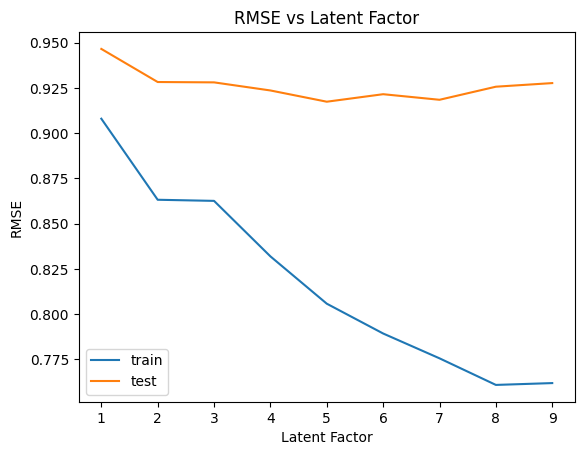

2024/09/01 18:13:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run Keras + Genres at: http://127.0.0.1:5000/#/experiments/753183866456602941/runs/e2ae1392425f4373a451848d6fb38b20.
2024/09/01 18:13:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/753183866456602941.


Best RMSE: 0.9174209833145142 for latent_factor=5


In [21]:
with mlflow.start_run(run_name="Keras + Genres"):
    # split dataset
    eval_size = 0.1
    test_size = 0.2
    ratings_train, ratings_val = train_test_split(ratings_with_genres, test_size=eval_size)
    ratings_train, ratings_test = train_test_split(ratings_train, test_size=test_size)
    max_rating = ratings_with_genres.rating.max()
    min_rating = ratings_with_genres.rating.min()

    mse_train = []
    mse_test = []
    best_lf = 0
    best_mse = float('inf')
    epochs=100
    latent_factor_list = list(range(1,10))
    model = build_keras_model(n_users, n_movies, n_genres)
    model.summary()
    _ = plot_model(model, to_file="keras-model.png", show_layer_names=True, show_layer_activations=True,show_trainable=True)
    for lf in tqdm(latent_factor_list):
        model = build_keras_model(n_users, n_movies, n_genres, latent_factors=lf, max_rating=max_rating, min_rating=min_rating)

        history = model.fit(
            [ratings_train.user_id, ratings_train.movie_id, ratings_train[genres_cols]], 
            ratings_train.rating,
            batch_size=320,
            validation_data=([ratings_test.user_id, ratings_test.movie_id, ratings_test[genres_cols]], ratings_test.rating), 
            epochs=epochs,
            verbose=0
        )
        metrics_train = model.evaluate([ratings_train.user_id, ratings_train.movie_id, ratings_train[genres_cols]], ratings_train.rating)
        metrics_val = model.evaluate([ratings_val.user_id, ratings_val.movie_id, ratings_val[genres_cols]], ratings_val.rating)
        
        mse_train.append(metrics_train[1])
        mse_test.append(metrics_val[1])

        # Log RMSE for each k
        mlflow.log_metric(f'rmse_train_lf_{lf}', metrics_train[1])
        mlflow.log_metric(f'rmse_test_lf_{lf}', metrics_val[1])

        if metrics_val[1] < best_mse:
            best_mse = metrics_val[1]
            best_lf = lf
            
    plt.plot(latent_factor_list, mse_train, label='train')
    plt.plot(latent_factor_list, mse_test, label='test')
    plt.xlabel('Latent Factor')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title("RMSE vs Latent Factor")

    # Save the plot to a file
    plt_path = "rmse_vs_latent_factor.png"
    plt.savefig(plt_path)
    plt.show()
    plt.close()

    # Log parameters, best latent_factor, best rmse and the plot
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("latent_factor", latent_factor_list)
    mlflow.log_metric("best_rmse", best_mse)
    mlflow.log_param("best_lf", best_lf)
    mlflow.log_artifact(plt_path)
    mlflow.log_artifact("keras-model.png")
    
    print(f"Best RMSE: {best_mse} for latent_factor={best_lf}")

## Keras + Users Data

### Prepare Data

In [22]:
users_data = pd.merge(
    users[["id", "Occupation"]],
    people[["id", "year of birth", "Gender"]],
    on="id"
)
users_data.id = users_data.id.apply(lambda x: user2Idx[x])

In [23]:
users_data["age"] = dt.now().year - users_data["year of birth"]
users_data.drop("year of birth", inplace=True, axis=1)
users_data["Gender"] = users_data["Gender"].apply(lambda x: 1 if x == "F" else 0)

In [24]:
encoder = OneHotEncoder(sparse_output=False)
occupation_encoded  = encoder.fit_transform(users_data.Occupation.to_frame())
occupation_encoded_df = pd.DataFrame(occupation_encoded, columns=encoder.get_feature_names_out(['Occupation']))
users_data = pd.concat([users_data.drop('Occupation', axis=1), occupation_encoded_df], axis=1)

In [25]:
user_data_cols = list(users_data.columns)
user_data_cols.remove("id")
n_data = len(user_data_cols)

In [26]:
ratings_with_users_data = pd.merge(
    ratings,
    users_data,
    left_on="user_id",
    right_on="id"
)

### Model

In [27]:
def build_keras_model(
    users_number, 
    movies_number, 
    data_number,
    max_rating=5,
    min_rating=1,
    latent_factors=5, 
    loss="mean_squared_error", 
    learning_rate=0.001, 
    metrics=["root_mean_squared_error"]
):
    movie_input = Input(shape=[1], name='Item')
    user_input = Input(shape=[1], name='User')
    user_data_input = Input(shape=[data_number], name='User Data')

    # Movie Embedding Layer
    movie_embedding = Embedding(
        movies_number + 1,
        latent_factors,
        embeddings_regularizer=l2(0.001),
        name='Movie-Embedding'
    )(movie_input)
    
    movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

    # User Embedding Layer
    user_embedding = Embedding(
        users_number + 1, 
        latent_factors, 
        embeddings_regularizer=l2(0.001),
        name='User-Embedding'
    )(user_input)

    user_vec = Flatten(name='FlattenUsers')(user_embedding)
    # prod = Dot(axes=1, name='DotProduct')([user_vec, movie_vec])
    
    # Concatenate the movie_vec with the genre_input
    concat = Concatenate(name='Concatenate')([user_vec, movie_vec, user_data_input])
    full_connect = Dense(50,name='FullyConnected', activation='relu', kernel_regularizer=l2(0.001))(concat)
    x = Dense(1, activation='sigmoid',name='Activation')(full_connect)
    score = Lambda(lambda z: (max_rating - min_rating) * z + min_rating, name="Standarization")(x)
    model = Model(inputs=[user_input, movie_input, user_data_input], outputs=score)
    model.compile(Adam(learning_rate=learning_rate), loss=loss, metrics=metrics)
    return model

### Train Model

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User-Embedding (Embedding)    │ (None, 1, 5)              │           4,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Movie-Embedding (Embedding)   │ (None, 1, 5)              │           8,415 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUsers (Flatten)        │ (None, 5)                 │               0 │ User-Embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenMovies (Flatten)       │ (None, 5)                 │               0 │ Movie-Embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User Data (InputLayer)        │ (None, 24)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Concatenate (Concatenate)     │ (None, 34)                │               0 │ FlattenUsers[0][0],        │
│                               │                           │                 │ FlattenMovies[0][0], User  │
│                               │                           │                 │ Data[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FullyConnected (Dense)        │ (None, 50)                │           1,750 │ Concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Activation (Dense)            │ (None, 1)                 │              51 │ FullyConnected[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Standarization (Lambda)       │ (None, 1)                 │               0 │ Activation[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,936 (58.34 KB)

 Trainable params: 14,936 (58.34 KB)

 Non-trainable params: 0 (0.00 B)

  0%|                                                                                                                                                                                                        | 0/9 [00:00<?, ?it/s]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - loss: 0.8467 - root_mean_squared_error: 0.9041
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 0.9035 - root_mean_squared_error: 0.9349


 11%|█████████████████████▎                                                                                                                                                                          | 1/9 [00:26<03:34, 26.82s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - loss: 0.8496 - root_mean_squared_error: 0.9047
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.9050 - root_mean_squared_error: 0.9348


 22%|██████████████████████████████████████████▋                                                                                                                                                     | 2/9 [00:52<03:02, 26.06s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step - loss: 0.8532 - root_mean_squared_error: 0.9057
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.9111 - root_mean_squared_error: 0.9371


 33%|████████████████████████████████████████████████████████████████                                                                                                                                | 3/9 [01:18<02:37, 26.22s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step - loss: 0.8605 - root_mean_squared_error: 0.9087
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.9132 - root_mean_squared_error: 0.9372


 44%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 4/9 [01:44<02:09, 25.92s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step - loss: 0.8578 - root_mean_squared_error: 0.9072
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.9122 - root_mean_squared_error: 0.9367


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 5/9 [02:10<01:44, 26.04s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - loss: 0.8690 - root_mean_squared_error: 0.9141
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.9286 - root_mean_squared_error: 0.9461


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 6/9 [02:36<01:17, 25.89s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - loss: 0.8563 - root_mean_squared_error: 0.9063
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.9063 - root_mean_squared_error: 0.9334


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7/9 [03:01<00:51, 25.81s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - loss: 0.8322 - root_mean_squared_error: 0.8844
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.9086 - root_mean_squared_error: 0.9265


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8/9 [03:27<00:25, 25.80s/it]

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step - loss: 0.8490 - root_mean_squared_error: 0.9020
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.9072 - root_mean_squared_error: 0.9337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:53<00:00, 25.97s/it]


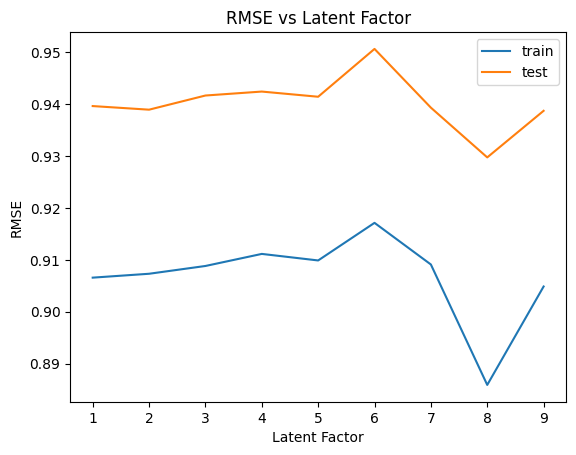

2024/09/01 18:17:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run Keras + UserData at: http://127.0.0.1:5000/#/experiments/753183866456602941/runs/31ec0b736f1d4c90aeb865ddbd165602.
2024/09/01 18:17:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/753183866456602941.


Best RMSE: 0.9296980500221252 for latent_factor=8


In [28]:
with mlflow.start_run(run_name="Keras + UserData"):
    # split dataset
    eval_size = 0.1
    test_size = 0.2
    ratings_train, ratings_val = train_test_split(ratings_with_users_data, test_size=eval_size)
    ratings_train, ratings_test = train_test_split(ratings_train, test_size=test_size)
    max_rating = ratings_with_users_data.rating.max()
    min_rating = ratings_with_users_data.rating.min()

    mse_train = []
    mse_test = []
    best_lf = 0
    best_mse = float('inf')
    epochs=100
    latent_factor_list = list(range(1,10))
    model = build_keras_model(n_users, n_movies, n_data)
    model.summary()
    _ = plot_model(model, to_file="keras-model.png", show_layer_names=True, show_layer_activations=True,show_trainable=True)
    for lf in tqdm(latent_factor_list):
        model = build_keras_model(n_users, n_movies, n_data, latent_factors=lf, max_rating=max_rating, min_rating=min_rating)

        history = model.fit(
            [ratings_train.user_id, ratings_train.movie_id, ratings_train[user_data_cols]], 
            ratings_train.rating,
            batch_size=320,
            validation_data=([ratings_test.user_id, ratings_test.movie_id, ratings_test[user_data_cols]], ratings_test.rating), 
            epochs=epochs,
            verbose=0
        )
        metrics_train = model.evaluate([ratings_train.user_id, ratings_train.movie_id, ratings_train[user_data_cols]], ratings_train.rating)
        metrics_val = model.evaluate([ratings_val.user_id, ratings_val.movie_id, ratings_val[user_data_cols]], ratings_val.rating)
        
        mse_train.append(metrics_train[1])
        mse_test.append(metrics_val[1])

        # Log RMSE for each k
        mlflow.log_metric(f'rmse_train_lf_{lf}', metrics_train[1])
        mlflow.log_metric(f'rmse_test_lf_{lf}', metrics_val[1])

        if metrics_val[1] < best_mse:
            best_mse = metrics_val[1]
            best_lf = lf
            
    plt.plot(latent_factor_list, mse_train, label='train')
    plt.plot(latent_factor_list, mse_test, label='test')
    plt.xlabel('Latent Factor')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title("RMSE vs Latent Factor")

    # Save the plot to a file
    plt_path = "rmse_vs_latent_factor.png"
    plt.savefig(plt_path)
    plt.show()
    plt.close()

    # Log parameters, best latent_factor, best rmse and the plot
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("latent_factor", latent_factor_list)
    mlflow.log_metric("best_rmse", best_mse)
    mlflow.log_param("best_lf", best_lf)
    mlflow.log_artifact(plt_path)
    mlflow.log_artifact("keras-model.png")
    
    print(f"Best RMSE: {best_mse} for latent_factor={best_lf}")